#Generative Adversarial Networks, or GANs, are a deep-learning-based generative model.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.

**Generator**. Model that is used to generate new plausible examples from the problem domain.
**Discriminator**. Model that is used to classify examples as real (from the domain) or fake (generated).

model colaps
vanishing gradient 


In [1]:
import os
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import LeakyReLU
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, UpSampling2D

from keras import backend as K
from keras import initializers
from keras.datasets import mnist
from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model

# Load MNIST data
1. This is an unsupervised problem. So, we don't need the labels and we can remove y_train
2. The training sample size is 60000 and the output is an image of 28*28 or 784 
3. We should normalize the data between (-1,1): 
  - each pixcle is between (0,255) --> (-127.5, 127.5) --> (min,max)
z = (xi – min(x))/max(x)
4. Data should be alway np.array and reshaped 

In [2]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

In [3]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [5]:
type(X_train)

numpy.ndarray

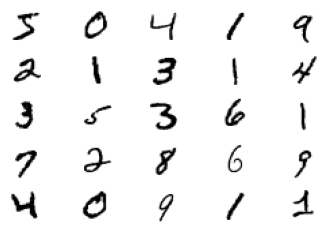

In [6]:
# Plot 25 images from the training dataset
for i in range(25):
  # define subplot
  plt.subplot(5, 5, i+1)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(X_train[i], cmap='gray_r')
  # plt.imshow(X_train[i])

plt.show()

In [7]:
# So, we only to normalize and reshape it!
# if it weren't np.array:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [8]:
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [9]:
# If you google colab doesn't have a high RAM!
X_train = X_train[:15000] 
y_train = y_train[:15000] 

In [10]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Generator**

- This network takes input from a vector with length 100 with random distribution and creates fake images.

- TanH Activation and Scaling: tanh activation function in the generator chenges scale of all pixel values to the range [-1, 1].

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

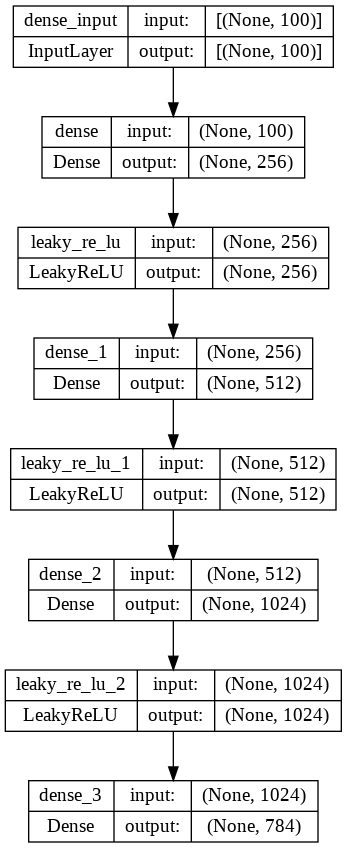

In [11]:
generator = Sequential()
generator.add(Dense(256, input_dim = randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation = 'tanh'))

generator.compile(loss = 'binary_crossentropy', optimizer = adam)
# summarize the discriminator
generator.summary()
# plot the discriminator
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

**Discriminator**

- This network takes an image as an input and determines whether this image is real or has been faked by the generator network!
- We will also add dropout to this network so that it works well for images that it has not seen.

- We should use a leaky ReLU to allow gradients to flow backward through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

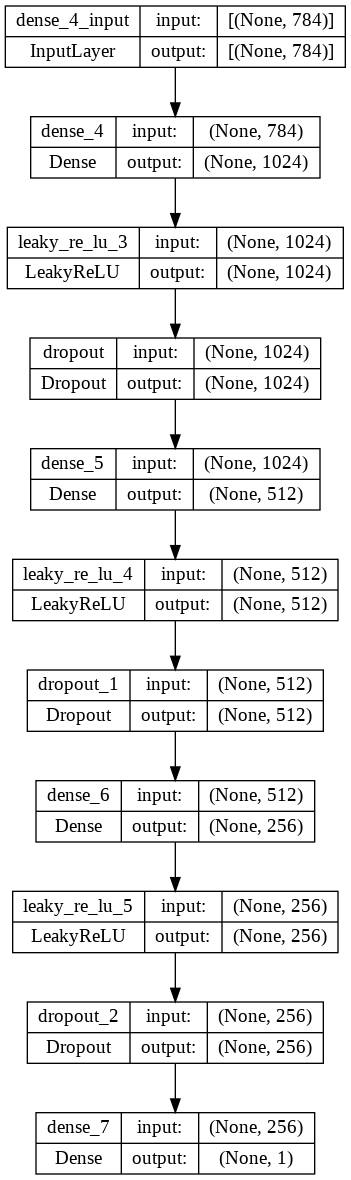

In [12]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim = 784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
# The discriminator takes a sample image from generator as an input and the output
# of the classification prediction to predict whether the sample is real or fake.
# So, because it's a binary classification, activation = 'sigmoid'
discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy', optimizer = adam)
# summarize the discriminator
discriminator.summary()
# plot the discriminator
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

**Final Network**

For every epoch, either one of generator or discriminator is kept trainable.So, we set the discriminator.trainable to False.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


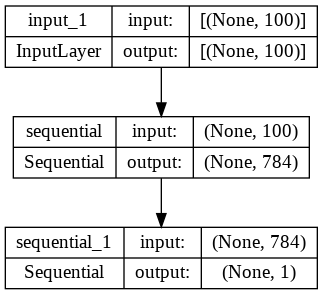

In [13]:
# Combined network --> GAN
discriminator.trainable = False
ganInput = Input(shape = (randomDim, ))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs = ganInput, outputs = ganOutput)
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

# summarize the gan
gan.summary()
# plot the gan
plot_model(gan, to_file='GAN_plot.png', show_shapes=True, show_layer_names=True)

**Plots**

- The plotLoss function plots the loss value in each iteration for each of the discriminator and generator networks.

- The plotGeneratedImages function plots 100 samples of the output of the generator network each time it is called.
- The saveModels function also stores the weights of each of the discriminator and generator networks.

In [14]:
out_dir = "./gan"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    out = os.path.join(out_dir, 'simple_gan_loss_epoch_%d.png' % epoch)
    plt.savefig(out)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    out = os.path.join(out_dir, 'simple_gan_generated_image_epoch_%d.png' % epoch)
    plt.savefig(out)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./simple_gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./simple_gan_discriminator_epoch_%d.h5' % epoch)

**Gan Traning**

In [15]:
epochs=20
# for each iteration for generator a mini-batch of 128 
# and for discriminator a mini-batch of 256 (128 real, 128 fake)
batchSize=128

batchCount = X_train.shape[0]//batchSize # (60000/128)
print('Epoches: ', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

Epoches:  20
Batch size: 128
Batches per epoch: 117


In [ ]:
for e in range(1, epochs+1):
  print('-'*15, 'Epoch %d'% e, '-'*15)
  sys.stdout.flush()
  for _ in tqdm(range(batchCount)):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batchSize, randomDim])

    # Because we want to train Discriminator first, we should define real data too
    # This code gives us 128 random numbers between (0, 60000), which is real data
    # and its shape is (128, 784)
    imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
    # Generate fake MNIST images
    generatedImages = generator.predict(noise)
    # print np.shape(imageBatch), np.shape(generatedImages)

    # Now, we concatanate these two inputs images (real and fake to train the discriminator)
    # So, its shape is (256, 784)
    X = np.concatenate([imageBatch, generatedImages])

    # Labels for generated and real data
    # -------------------------------------
    # One-sided label smoothing
    # real_label 1 0r 0.9 --> [0:128]
    # fake_label = 0 --> [128:256]
    # In Gan, if we have a very big data, we might encouter to Vanishing Gradiant
    # or mode collaps, we should apply classification teqnic, here, we use
    # one-side smoothing
    yDis = np.zeros(2*batchSize)
    yDis[:batchSize] = 0.9

    # Train discriminator
    discriminator.trainable = True
    # train_on_batch only trains one iteration and is different with fit
    # we trained discriminator, and save the error in dloss
    dloss = discriminator.train_on_batch(X, yDis)


    # Now, we should train the GAN, now the generator should concaenater 
    # to the discriminator and we freez the discriminator and label should
    # be miss-leading for the generator
    # GAN is a generator, which is connected to a siscriminator and the discriminator 
    # isn't trained. 


    # Train generator
    noise = np.random.normal(0, 1, size=[batchSize, randomDim])
    yGen = np.ones(batchSize)
    discriminator.trainable = False
    gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 20 == 0:
        plotGeneratedImages(e)
        saveModels(e)

# Plot losses from every epoch
plotLoss(e)

**Sources:**

https://www.datacamp.com/community/tutorials/generative-adversarial-networks

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

https://www.datacamp.com/tutorial/generative-adversarial-networks
